# Submission Creator Notebook

This notebook is used to create submissions which can be submitted under https://codalab.ai-cup.uni-passau.de/competitions/79#results

Upload all submissions also to https://www.notion.so/Submission-Tracker-623685dd3444432d8d2d8b1cfd6ea77e

## Model Training

In [1]:
from notebooks.submission.submission_model_trainer import execute_training
from session_validation.session_params import SessionParams
from session.session import Session
from notebooks.submission.configs.config import config_8c58c462

REDUCTION_FACTOR = 0.4

config = config_8c58c462
config['session_param_id'] = 302
config['training_config']['epochs'] = 30
session: Session = execute_training(**config)

2022-07-08 12:16:23.001099   [DataAugmenter] Added a Convolve Augmenter with window_type=bohman and window_size=5
2022-07-08 12:16:23.002134   [Session] Initializing ...
2022-07-08 12:16:23.003098   [Session] Syncing existing training runs ...
2022-07-08 12:16:23.003098   [Session] Checking for previously run epoch logs and stored weights ...
2022-07-08 12:16:23.004096   [Session] Created checkpoint directory C:\Informatik\workspaces\workspace_python\AI-Cup\models\444444440302\ckpts\ ...
2022-07-08 12:16:23.004096   [Session] Synced logs and weights at epoch 0.
2022-07-08 12:16:23.004096   [Session] Finished initialization.
2022-07-08 12:16:23.004096   [Session] Started initialize subroutine ...
2022-07-08 12:16:23.004096   [Session] Retrieving model ...
2022-07-08 12:16:24.200098   [Session] Retrieved model with 87918 parameters successfully.
2022-07-08 12:16:24.201099   [Session] Compiling model ...
2022-07-08 12:16:24.213098   [Session] Compiled model successfully.
2022-07-08 12:16:

In [2]:
from cup_scripts.utils import load_train, load_test
X_test, metadata_test = load_test()
len(X_test) # should be 690

690

## Prediction

In [3]:
### test hyperopt submission
#from hyperoptimization.callbacks.ray_submission_callback_functions import create_and_save_submission
#create_and_save_submission(session=session, reduction_factor=0.4, id="TEST_ID")

In [4]:
session = session[0]
predictions_as_ts , _   = session.get_predictions_as_ts()
print(f"Get get_predictions_as_ts result predictions: {len(predictions_as_ts)}")
print(f"Number of files of validation generator: {len(session.validation_generator.file_list)}")
# Should match

Get get_predictions_as_ts result predictions: 345
Number of files of validation generator: 345


## Cast Predictions from mask to List of Steps

In [5]:
from utils.util_functions import transform_predictions_to_ts
from cup_scripts.utils import check_result_format

predictions = transform_predictions_to_ts(predictions_as_ts)
check_result_format(predictions)

## Data Post-Processing

In [6]:
from data_processing.post_processing.post_processing_functions import join_dataset_steps
joined_predictions = join_dataset_steps(predictions)

### Reduce & Swap Result

In [7]:
# reduced
from utils.util_functions import reduce_list
    
reduced_joined_predictions = []
for prediction in joined_predictions:
    reduced_prediction = reduce_list(prediction, REDUCTION_FACTOR)
    reduced_joined_predictions.append(reduced_prediction)

check_result_format(reduced_joined_predictions)
print('Done')

Done


### Save result

In [8]:
from cup_scripts.utils import write_results
from utils.SYSCONFIG import SUBMISSIONS_PATH
from utils.util_functions import create_folder_if_not_exists

import os 
from datetime import datetime

create_folder_if_not_exists(SUBMISSIONS_PATH)

date_time = datetime.now().strftime("%m-%d-%Y_%H-%M-%S")
write_results(
    reduced_joined_predictions,
    filename=os.path.join(SUBMISSIONS_PATH,f"submission_joined_config-{config['session_param_id']}_{date_time}_reduced-{REDUCTION_FACTOR}.zip")
)
write_results(
    joined_predictions,
    filename=os.path.join(SUBMISSIONS_PATH,f"submission_joined_config-{config['session_param_id']}_{date_time}_FULL.zip")
)

2022-07-08 12:25:55.773515   [UtilFunctions] Found an existing folder for C:\Informatik\workspaces\workspace_python\AI-Cup\submissions


## Visualize Result

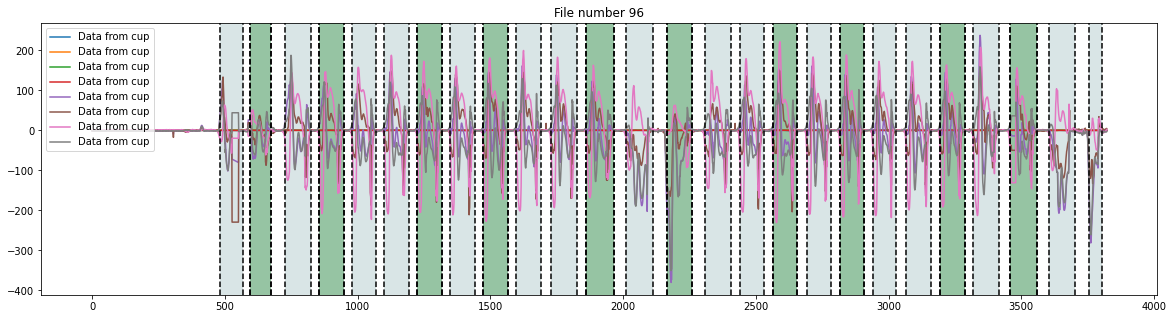

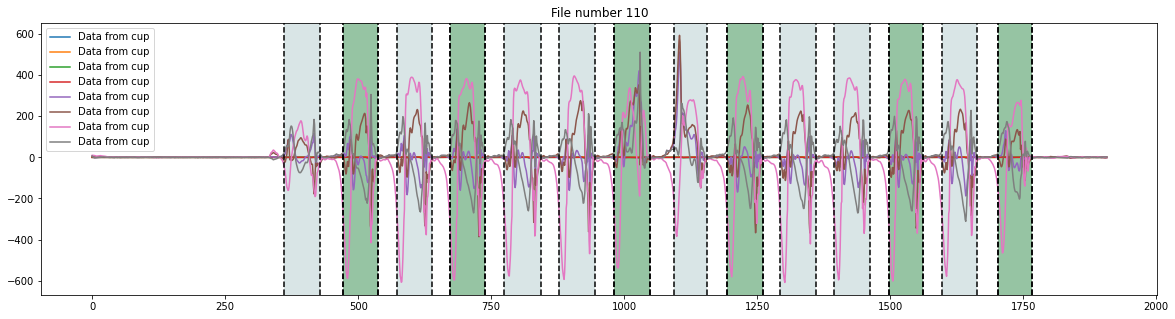

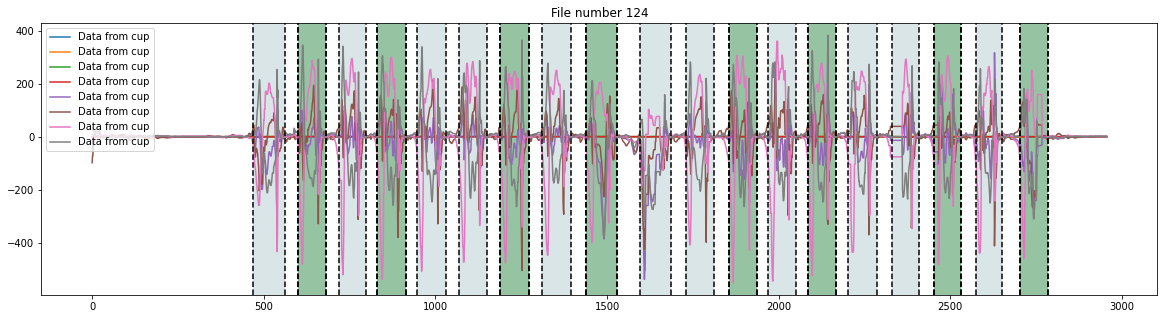

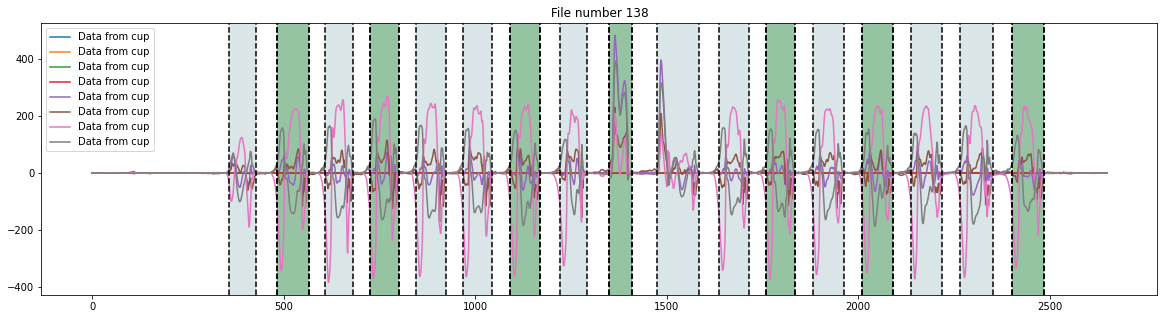

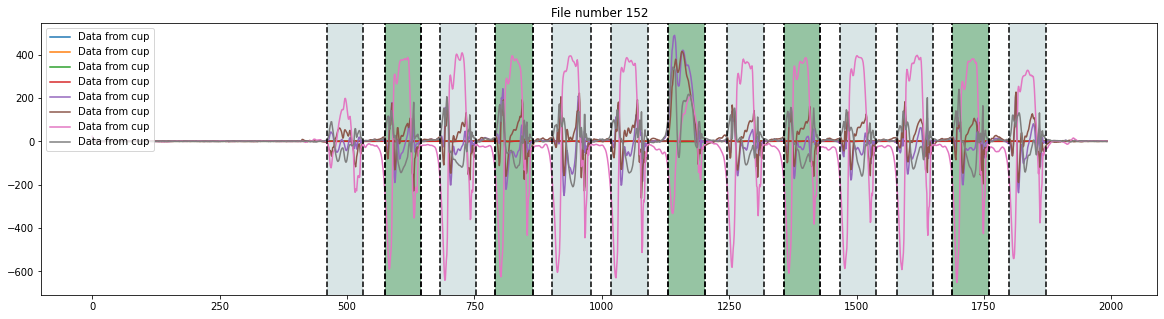

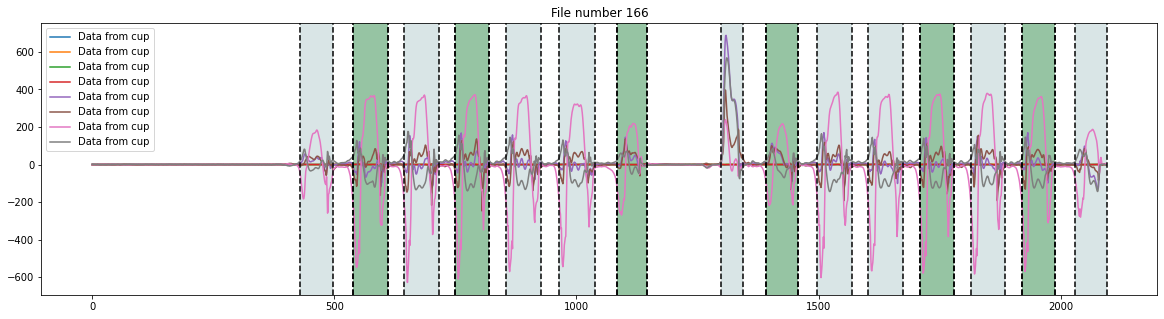

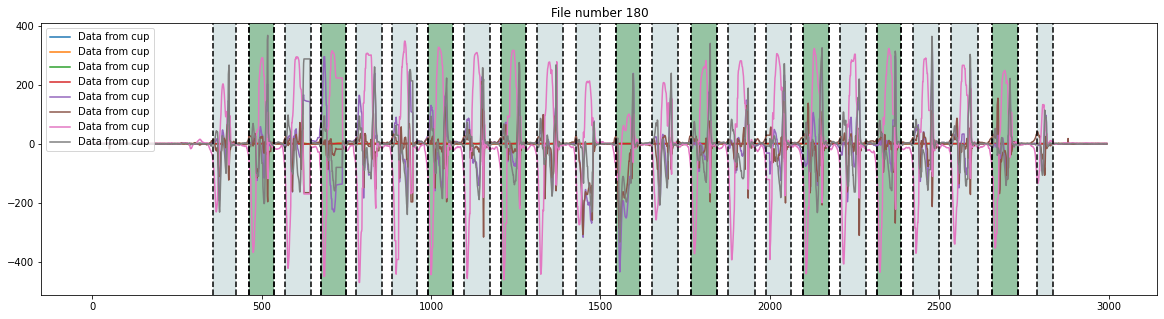

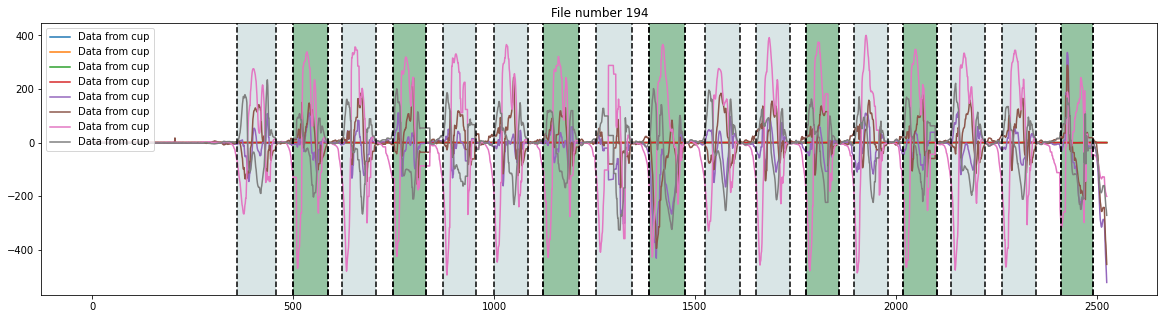

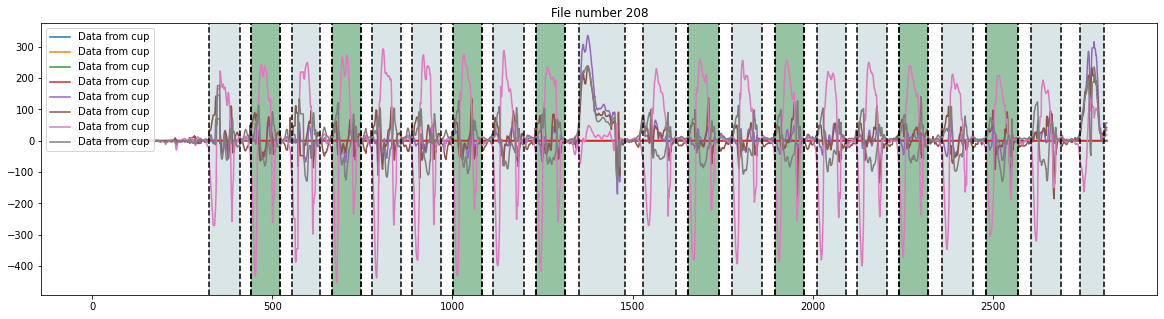

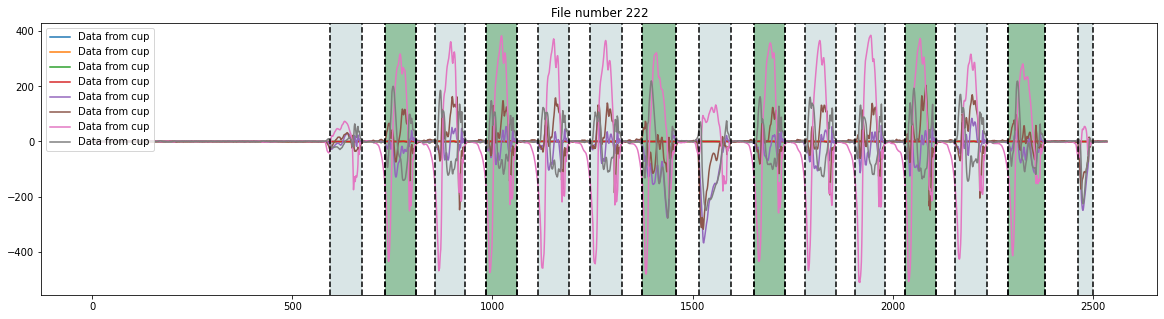

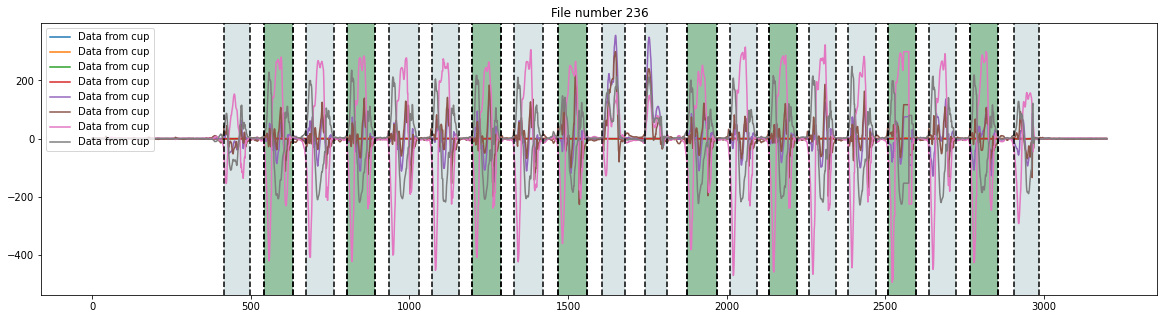

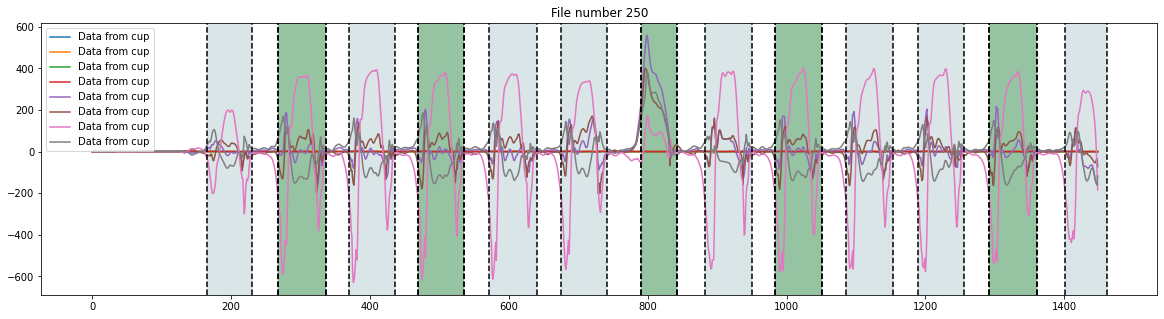

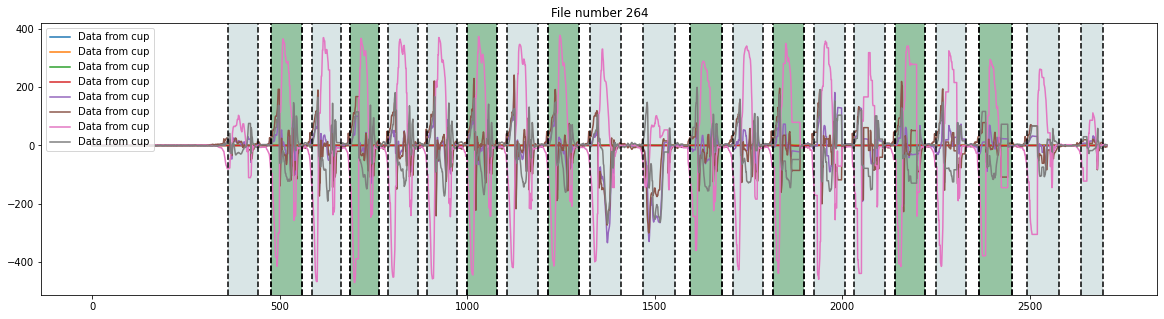

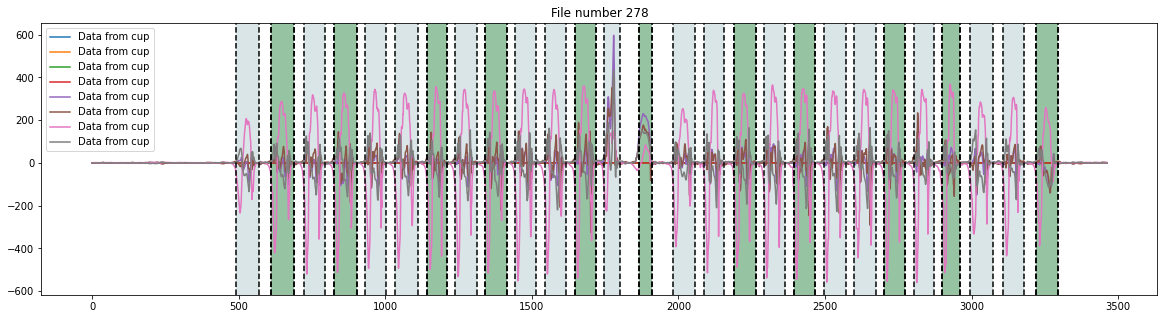

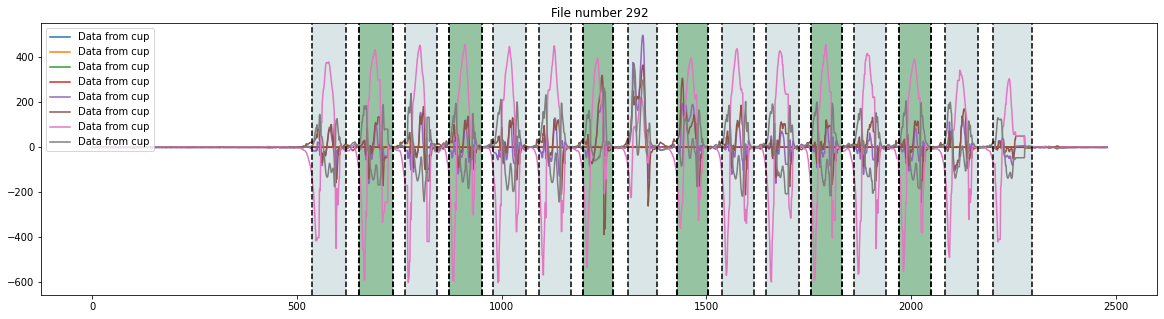

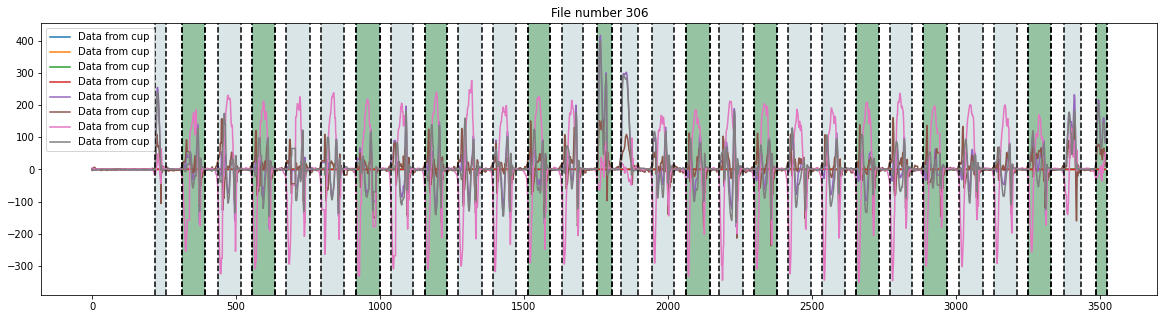

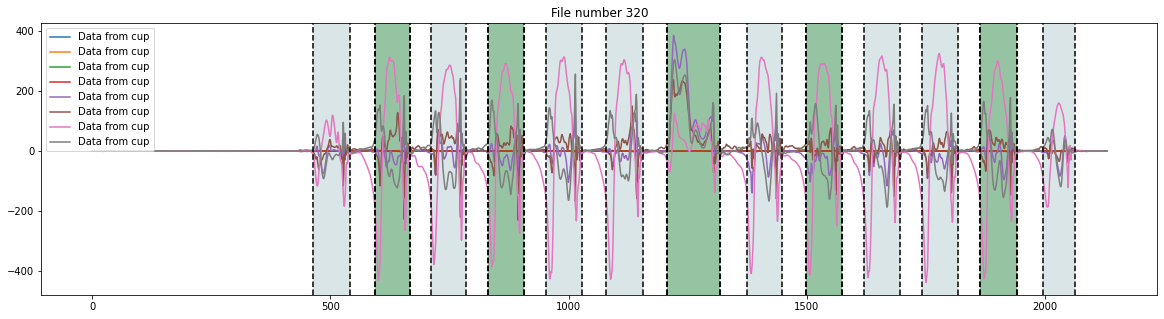

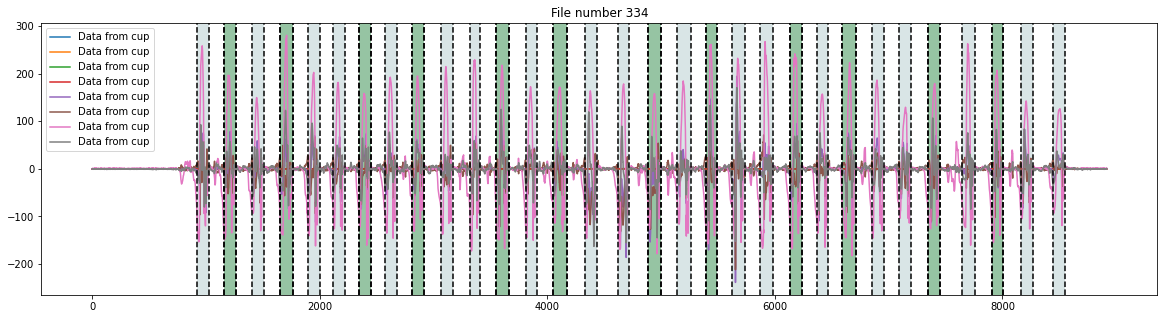

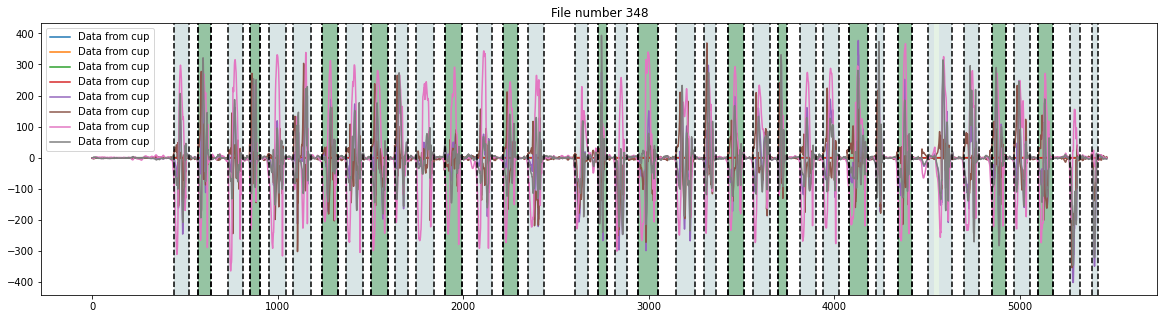

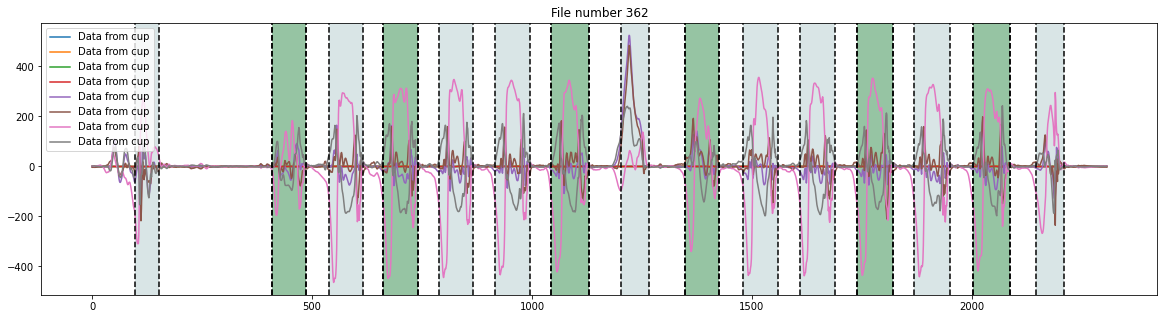

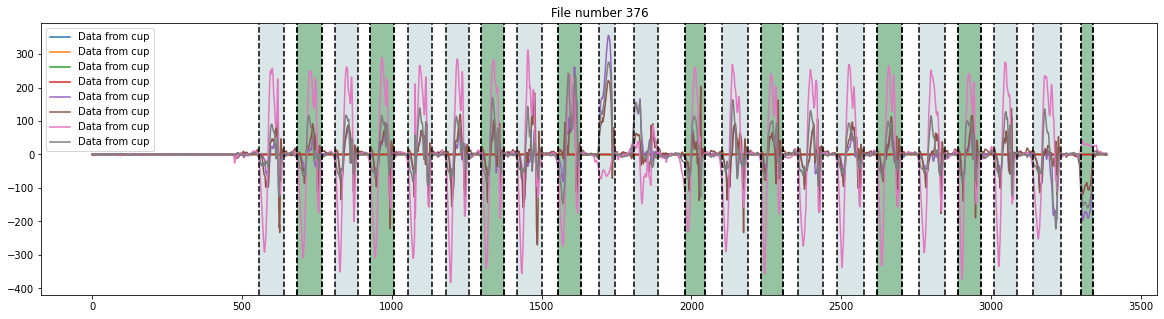

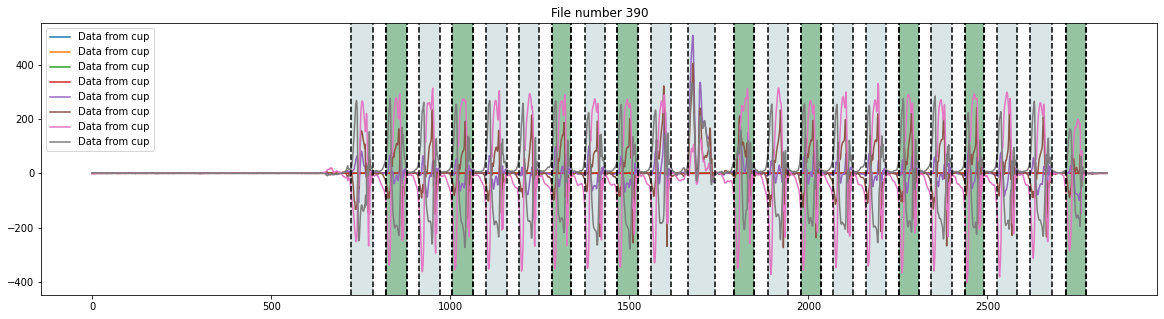

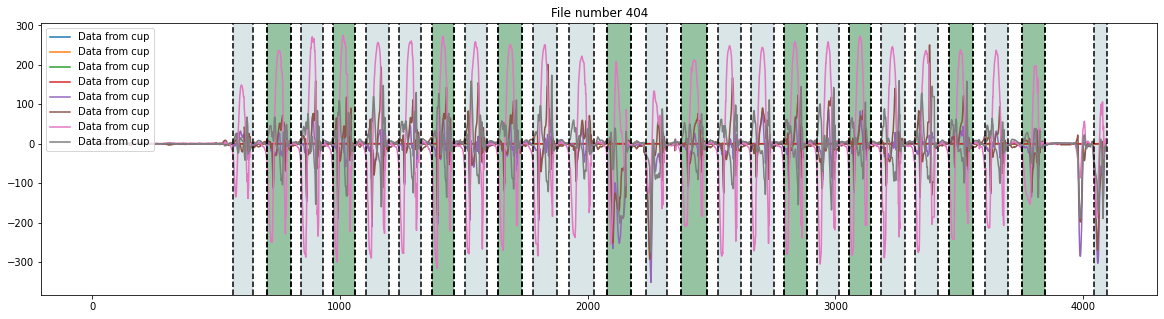

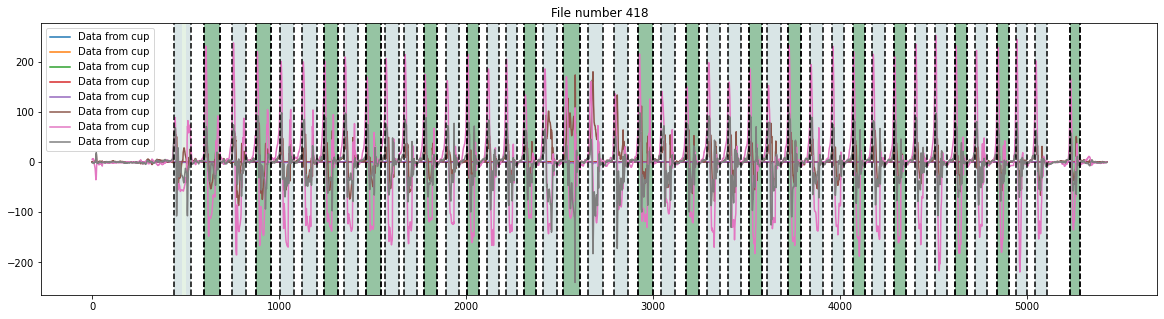

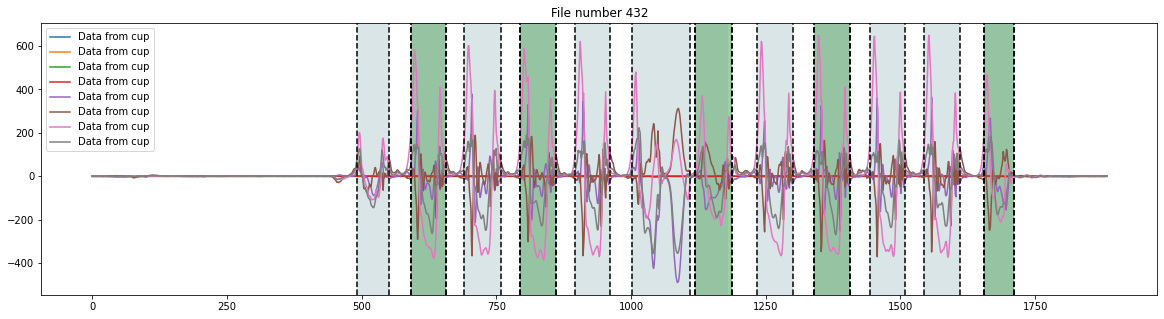

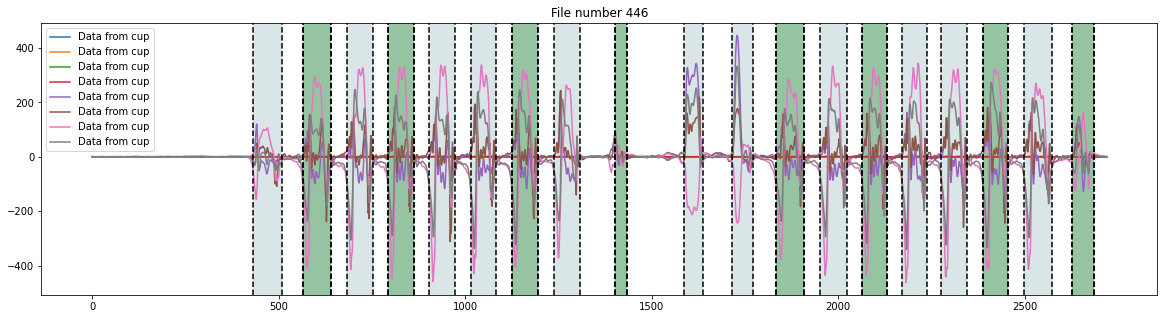

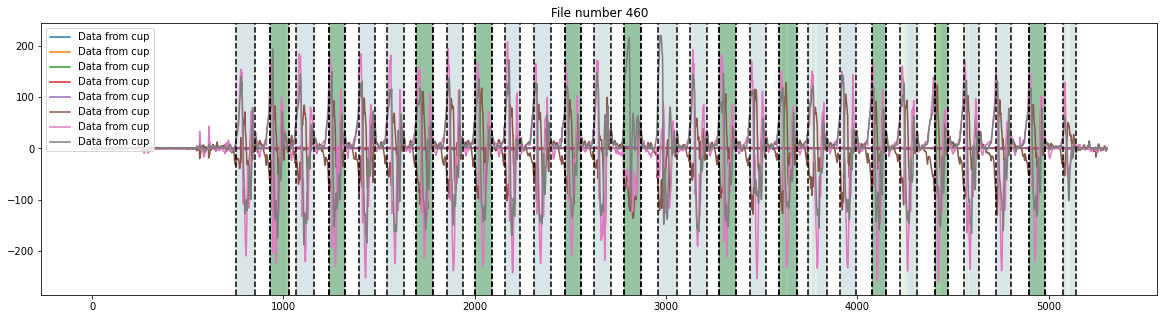

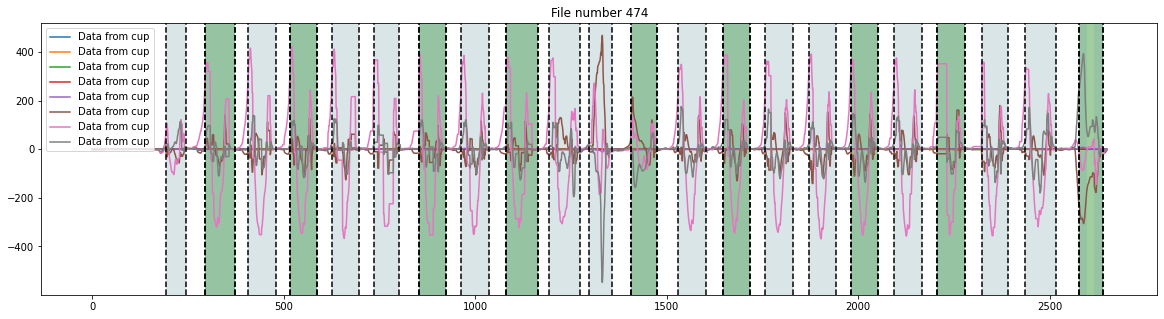

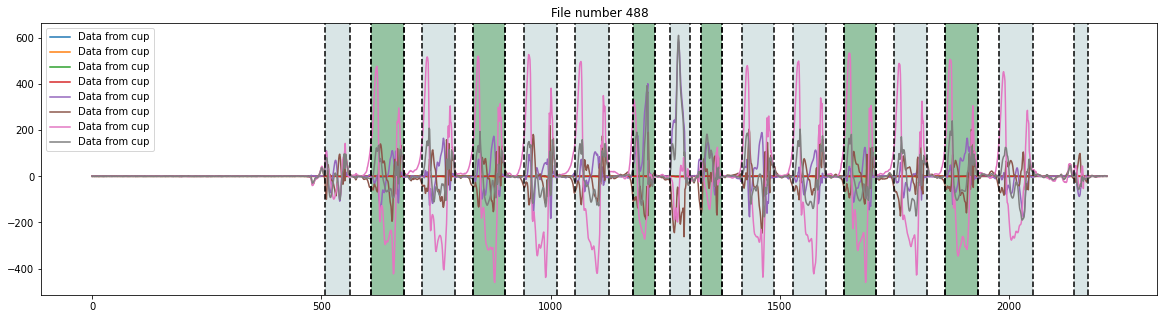

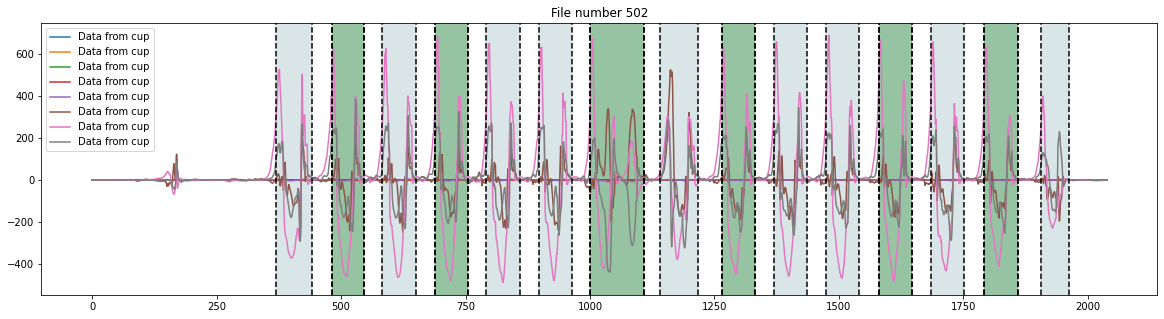

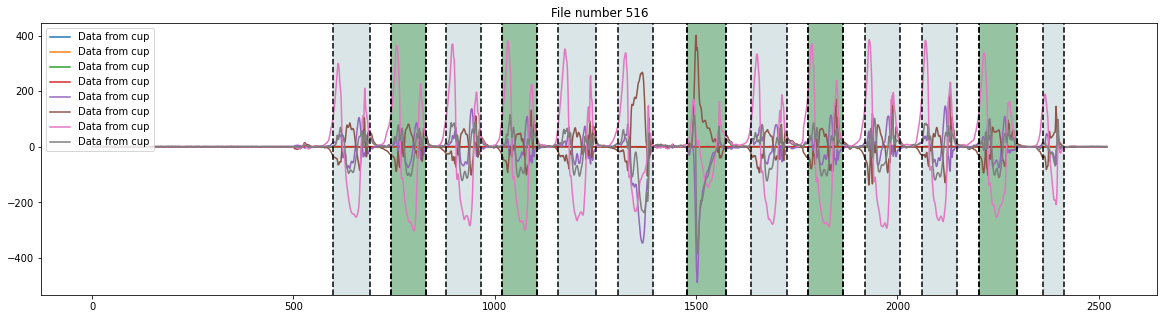

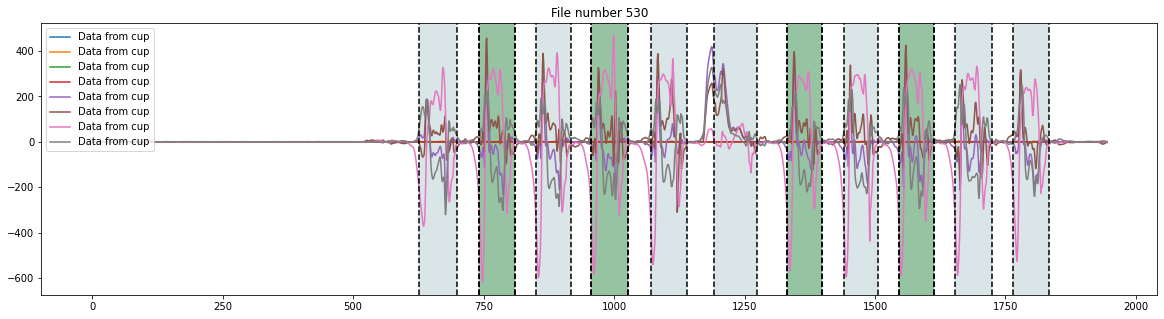

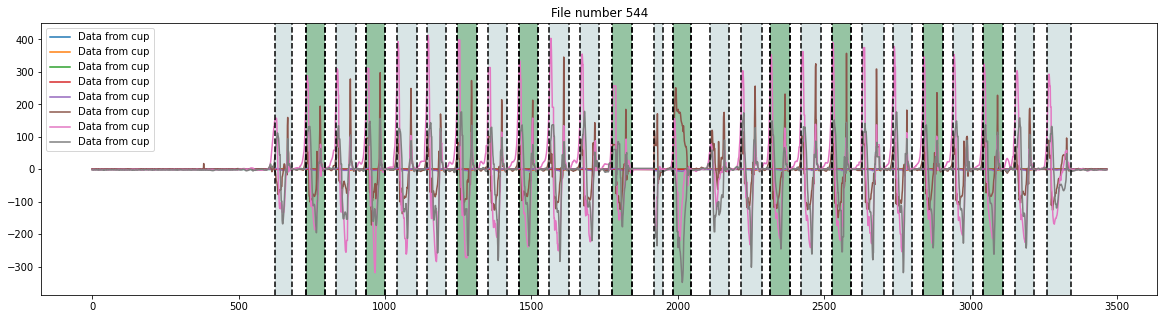

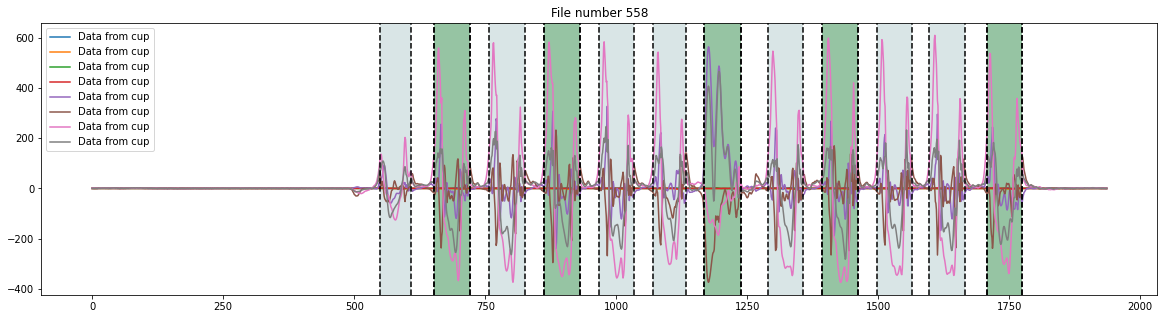

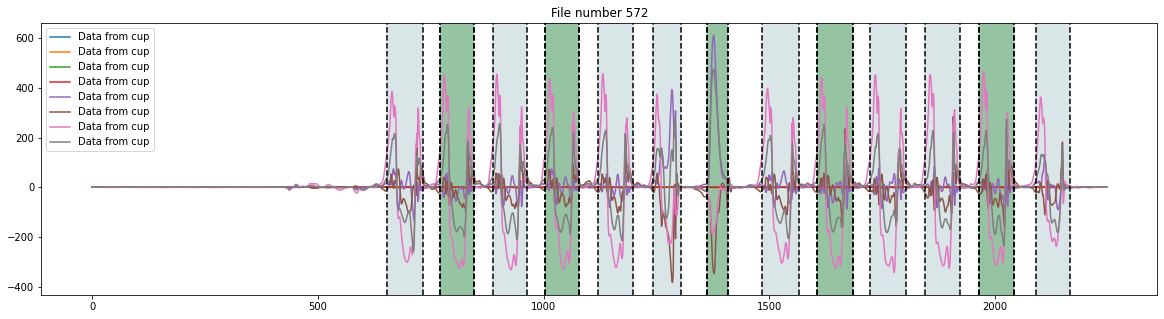

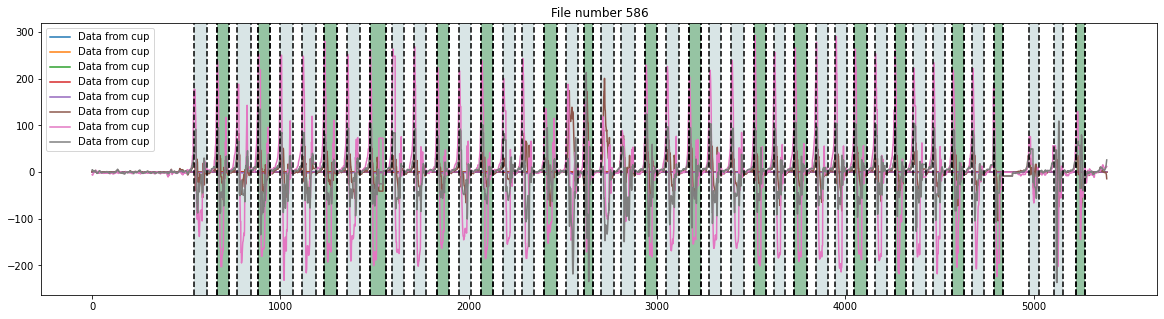

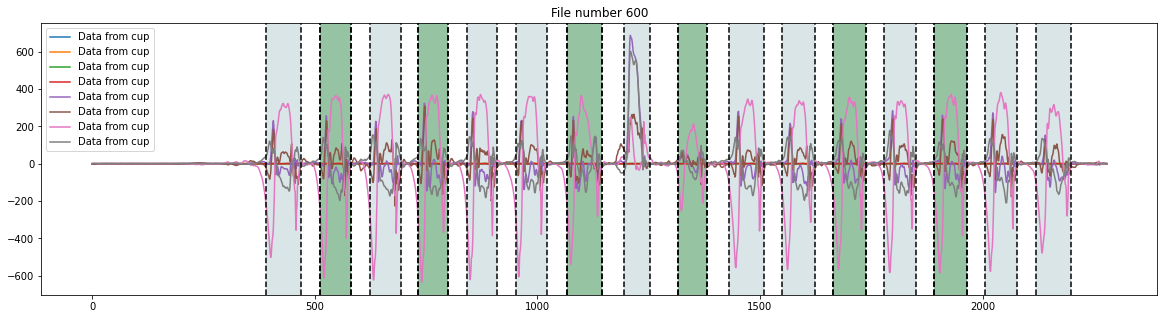

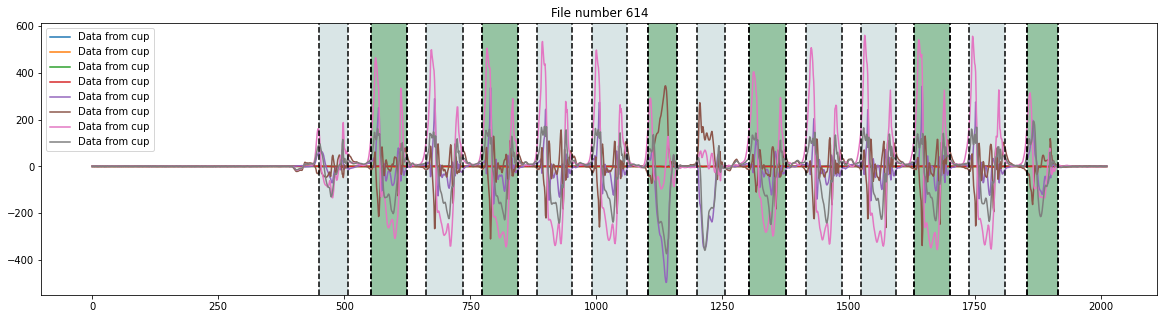

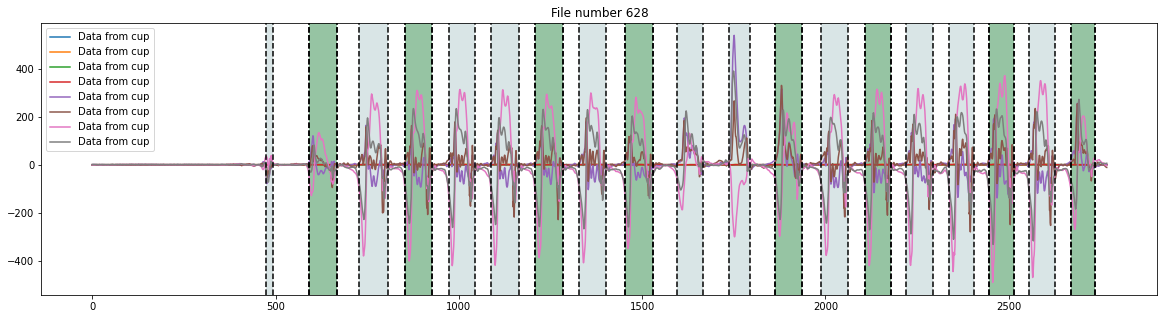

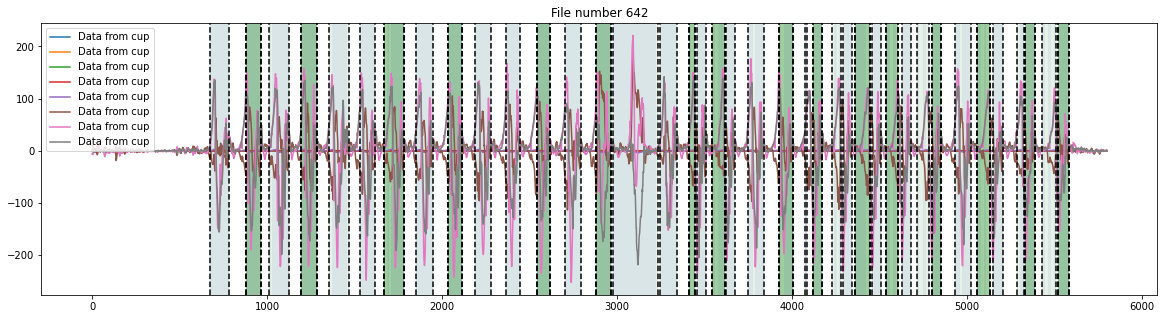

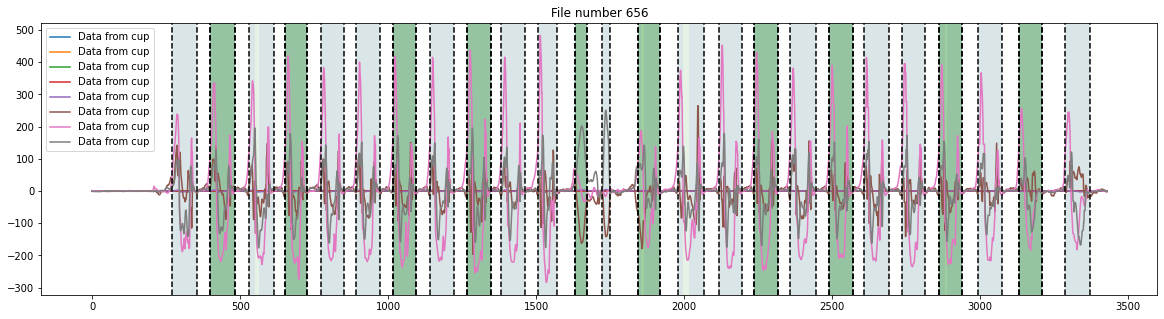

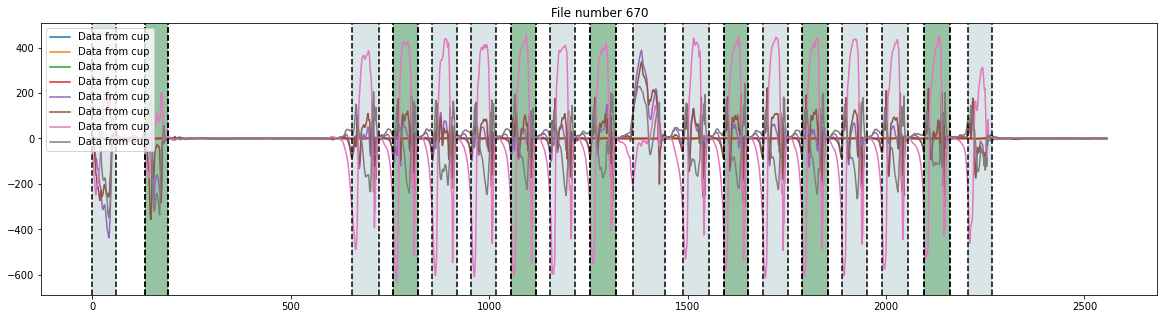

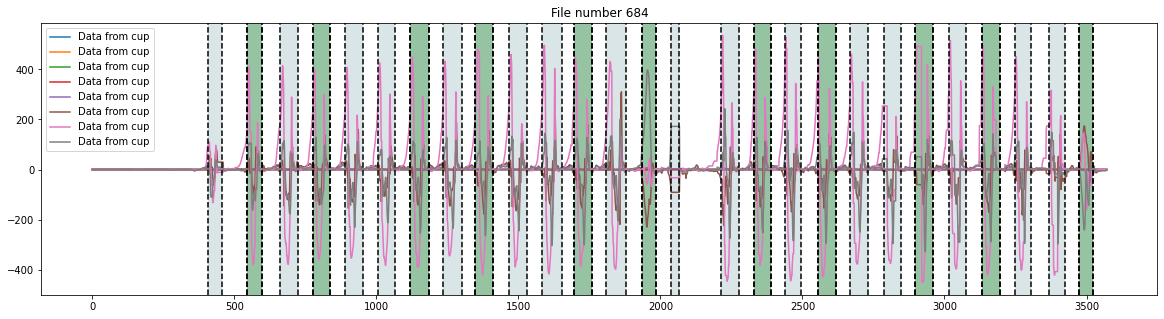

In [9]:

import matplotlib.pyplot as plt

max_x = 10000
plt.rcParams["figure.figsize"] = (20,5)
line_args = {"linestyle": "--", "color": "k"}
line_args2 = {"linestyle": "-", "color": "k"}
for index in range(96,len(X_test),14):

    plt.title(f'File number {str(index)}')

    x = X_test[index]
    subset = x.to_numpy()[:max_x,:8]

    # Cup data
    plots = plt.plot(subset, label="Data from cup")

    for x in range(len(plots)):
        plot = plots[x]
        alpha = 256 - round(128 / len(plots) * x +1)
        alpha = format(alpha, '02x')
        alpha = "80"
        #plot.set(color="#0000FF" + alpha)
    

    # Model predictions

    if True:
        for (start, end) in reduced_joined_predictions[index]:

            if start > max_x : break

            plt.axvline(start, **line_args)
            plt.axvline(end, **line_args)
            plt.axvspan(start, end, facecolor="g", alpha=0.3)

    if True:
        for (start, end) in joined_predictions[index]:
            plt.axvline(start, **line_args)
            plt.axvline(end, **line_args)
            plt.axvspan(start, end, facecolor="g", alpha=0.1)

    if True:
        for (start, end) in predictions[index]:
            plt.axvspan(start, end, facecolor="b", alpha=0.05)

    plt.legend(loc="upper left")
    #plt.ylim([-2,2])
    plt.show()

    # the problem is that the 1st batch is used all the time
